In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [93]:
import collections
from pathlib import Path
import json
import pprint
import os

import cv2
import numpy as np
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

## Import datasets

- Dataset is annotated by using [sloth](https://sloth.readthedocs.io/en/latest/)
- Annotation format: 
    - **Origin**: Top left conner of image
    - **x,y**: Top-left conner of bounding box.
    - **height**: Height of the bounding box.
    - **width**: Width of the bounding box.

In [9]:
PATH = Path('/home/tenzin/d2/data/')
list(PATH.iterdir())

[PosixPath('/home/tenzin/d2/data/myconfig.pyc'),
 PosixPath('/home/tenzin/d2/data/myconfig.py'),
 PosixPath('/home/tenzin/d2/data/labels.json'),
 PosixPath('/home/tenzin/d2/data/dataset-01'),
 PosixPath('/home/tenzin/d2/data/tub_17_18-08-03'),
 PosixPath('/home/tenzin/d2/data/tub_5_18-08-03'),
 PosixPath('/home/tenzin/d2/data/dataset-02')]

In [29]:
trn_j = json.load((PATH/'labels.json').open())  # list of images with annotation
pprint.pprint(trn_j[0])

{'annotations': [{'class': 'orange',
                  'height': 35.79507484025583,
                  'type': 'rect',
                  'width': 21.945789931823516,
                  'x': 0.6391977650045684,
                  'y': 8.30957094505939},
                 {'class': 'orange',
                  'height': 21.093526245150763,
                  'type': 'rect',
                  'width': 15.979944125114201,
                  'x': 57.74086477207935,
                  'y': 11.292493848414042},
                 {'class': 'green',
                  'height': 28.55083350353739,
                  'type': 'rect',
                  'width': 22.37192177515989,
                  'x': 24.50258099184179,
                  'y': 8.735702788395768},
                 {'class': 'green',
                  'height': 17.684471498459725,
                  'type': 'rect',
                  'width': 12.570889378423189,
                  'x': 83.52184129393027,
                  'y': 12.1447575350868},
 

In [26]:
trn_j[0].keys()

dict_keys(['class', 'filename', 'annotations'])

In [27]:
CLASS, FILENAME, ANNOTATION = 'class', 'filename', 'annotations'
trn_j[0][ANNOTATION][:2]

[{'class': 'orange',
  'height': 35.79507484025583,
  'type': 'rect',
  'width': 21.945789931823516,
  'x': 0.6391977650045684,
  'y': 8.30957094505939},
 {'class': 'orange',
  'height': 21.093526245150763,
  'type': 'rect',
  'width': 15.979944125114201,
  'x': 57.74086477207935,
  'y': 11.292493848414042}]

### Preprocessing the dataset
- Creating hash table to mapping id to name or filename

In [82]:
cats = {i: name for i, name in enumerate(['orange', 'green'])}
trn_fns = {int(dp[FILENAME].split('/')[-1].split('_')[0]):dp[FILENAME].split('/')[-1] for dp in trn_j}
trn_ids = list(trn_fns.keys())
trn_fns[22]

'22_cam-image_array_.jpg'

In [31]:
JPGS = 'dataset-02'  # images dir name

In [33]:
IMG_PATH = PATH/JPGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('/home/tenzin/d2/data/dataset-02/23710_cam_image_array_.jpg'),
 PosixPath('/home/tenzin/d2/data/dataset-02/14309_cam_image_array_.jpg'),
 PosixPath('/home/tenzin/d2/data/dataset-02/3884_cam-image_array_.jpg'),
 PosixPath('/home/tenzin/d2/data/dataset-02/16183_cam_image_array_.jpg'),
 PosixPath('/home/tenzin/d2/data/dataset-02/128_cam-image_array_.jpg')]

- We convert height/width into bottom-right and our x/y are consistent with numpy, which is top-left
- New annotation:
    - **x1,y1**: Top-left (which is same x, y)
    - **x2, y2**: Bottom left (x + width, y + height)

In [130]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[1]+bb[3]-1, bb[0]+bb[2]-1])

trn_anno = collections.defaultdict(lambda: [])
for dp in trn_j:
    dp_name = dp[FILENAME].split('/')[-1]
    dp_id = int(dp_name.split('_')[0])
    for ann in dp[ANNOTATION]: 
        bb = [ann['x'], ann['y'], ann['width'], ann['height']]
        bb = hw_bb(bb)
        cls = 0 if ann[CLASS] == "orange" else 1
        trn_anno[dp_id].append((bb, cls))
len(trn_anno)

248

In [104]:
im_a = trn_anno[1]; im_a  #x1, y1, x2, y2

[(array([ 8.30957095,  0.63919777, 29.25536088, 35.43427261]), 0),
 (array([11.29249385, 57.74086477, 26.27243797, 77.83439102]), 0),
 (array([ 8.73570279, 24.50258099, 30.10762456, 52.0534145 ]), 1),
 (array([ 12.14475754,  83.52184129,  23.71564691, 100.20631279]), 1),
 (array([ 18.32366926, 150.4245407 ,  27.33776758, 176.91004459]), 0)]

In [106]:
trn_fns[1]

'1_cam-image_array_.jpg'

In [107]:
trn_j[0][FILENAME]

'dataset-02/1_cam-image_array_.jpg'

In [110]:
trn_j[0]

{'annotations': [{'class': 'orange',
   'height': 35.79507484025583,
   'type': 'rect',
   'width': 21.945789931823516,
   'x': 0.6391977650045684,
   'y': 8.30957094505939},
  {'class': 'orange',
   'height': 21.093526245150763,
   'type': 'rect',
   'width': 15.979944125114201,
   'x': 57.74086477207935,
   'y': 11.292493848414042},
  {'class': 'green',
   'height': 28.55083350353739,
   'type': 'rect',
   'width': 22.37192177515989,
   'x': 24.50258099184179,
   'y': 8.735702788395768},
  {'class': 'green',
   'height': 17.684471498459725,
   'type': 'rect',
   'width': 12.570889378423189,
   'x': 83.52184129393027,
   'y': 12.1447575350868},
  {'class': 'orange',
   'height': 27.48550389519644,
   'type': 'rect',
   'width': 10.014098318404905,
   'x': 150.42454069774178,
   'y': 18.323669263464293}],
 'class': 'image',
 'filename': 'dataset-02/1_cam-image_array_.jpg'}

In [73]:
cats[trn_anno[1][0][1]], cats[trn_anno[1][2][1]]

('orange', 'green')

In [127]:
# to covert back to heght/width
def bb_hw(bb): return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

# sanity check
bb_sloth = [0.6391977650045684, 8.30957094505939, 21.945789931823516, 35.79507484025583]
bb_cr = hw_bb(bb_sloth)

print(bb_cr)
print('expected: {}, actual: {}'.format(bb_sloth, bb_hw(bb_cr)))

[ 8.30957095  0.63919777 43.10464579 21.5849877 ]
expected: [0.6391977650045684, 8.30957094505939, 21.945789931823516, 35.79507484025583], actual: [ 0.63919777  8.30957095 21.94578993 35.79507484]


In [89]:
## Using fastai open_image
def open_image(fn):
    """ Opens an image using OpenCV given the file path
    
    Arguments:
        fn: the file path of image
    Returns:
        The image in RBG format as numpy array floats normalization to range[0.0, 1.0]
    """
    
    flags = flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(str(fn)):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(str(fn)):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError('File not recognized by opencv: {}'.format(fn))
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [108]:
im = open_image(IMG_PATH/trn_fns[1])

In [109]:
im.shape

(120, 160, 3)

- Matplotlib's **plt.subplots** is a really useful wrapper for creating plots, regardless of whether you have more than one subplot.
- Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [112]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

- trick to making text visible regardless of background is to use white text with black outline, or visa versa.
- Here's how to do it in matplotlib.

In [98]:
def draw_outline(o, lw):
    ''' Drawing outline
    Arguments:
        o: matplotlib plotting object, like ax, plt
        lw: line width
    '''
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

- Note that * in argument lists is the splat operator. In this case it's a little shortcut compared to writing out b[-2],b[-1].

In [140]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='yellow', lw=2))
    #draw_outline(patch, 4)

In [147]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='black', fontsize=sz)
    #draw_outline(text, 1)

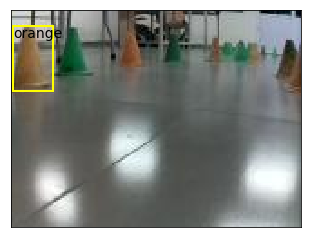

In [148]:
ax = show_img(im)
b = bb_hw(trn_anno[1][0][0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[trn_anno[1][0][1]])

- Showing all the labels

In [151]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [152]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(120, 160, 3)


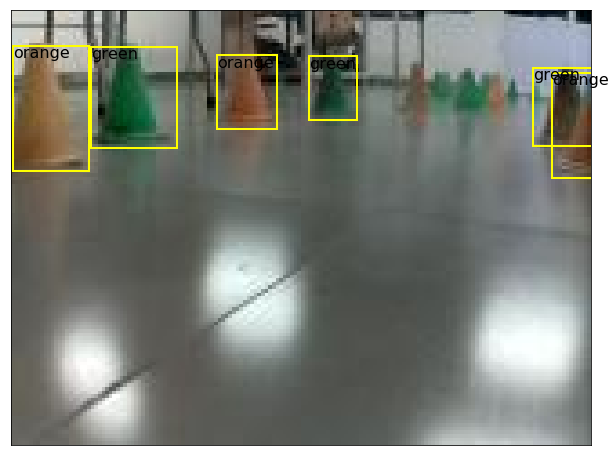

In [156]:
draw_idx(22)